# 4th Assignment: Sentiment Analysis with RNNs

---
>Vasileios Galanos <br>
>Registration Number p3351902 <br>
>vgalanos@aueb.gr

This notebook accompanied with the report given provides our solution to the 2nd assignment of the Text Analytics course at Data Science MSc at AUEB. <br>

#### Install required packages


In [2]:
%%capture
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install --upgrade tensorflow
!pip install emoji --upgrade

#### Mount drive to colab

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Check the GPU allocated

In [1]:
!nvidia-smi

Sun Jun 21 08:23:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Import all libraries for later use

In [4]:
import pandas as pd
import numpy as np
import pickle
import re
import matplotlib.pyplot as plt
import nltk
import re
import itertools
import emoji
import time
import os

import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score

from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup 
from nltk.stem import WordNetLemmatizer
from gensim.models.wrappers import FastText
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from tabulate import tabulate
from sklearn.metrics import auc
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [5]:
nltk.download('wordnet',quiet=True)
#nltk.download('stopwords',quiet=True)
nltk.download('punkt',quiet=True)

True

#### Download & unzip fasttext word embeddings

In [6]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

--2020-06-21 08:24:38--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  22.2MB/s    in 58s     

2020-06-21 08:25:37 (21.9 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



#### **Load fasttext embeddings**
To load fasttext pre-trained embeddings more efficiently, we can read only once the embeddings file and save:

1. A 2D np-array for the embedding vectors
2. A dictionary that maps each word to the row index of its embedding on the 2D np-array

In [7]:
idx = 0
vocab = {}
with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n',errors='ignore') as f:
    for l in f:
        line = l.rstrip().split(' ')
        if idx == 0:
            vocab_size = int(line[0]) + 2
            dim = int(line[1])
            vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
            vocab["__PADDING__"] = 0
            vocab["__UNK__"] = 1
            idx = 2
        else:
            vocab[line[0]] = idx
            emb = np.array(line[1:]).astype(np.float)
            if (emb.shape[0] == dim):
                vecs[idx,:] = emb
                idx+=1
            else:
                continue

    pickle.dump(vocab,open("/content/gdrive/My Drive/fasttext_voc.pkl" ,'wb'))
    np.save("/content/gdrive/My Drive/fasttext.npy",vecs)
    # Free ram
    vecs = None
    vocab = None
    emb = None

#### **Load embeddings np-array and mapping dictionary**



In [8]:
fasttext_embed = np.load("/content/gdrive/My Drive/fasttext.npy")
fasttext_word_to_index = pickle.load(open("/content/gdrive/My Drive/fasttext_voc.pkl", 'rb'))

#### Download a sentiment analysis dataset

In [9]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip "trainingandtestdata.zip"

--2020-06-21 08:40:45--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-06-21 08:40:46--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  25.1MB/s    in 3.1s    

2020-06-21 08:40:49 (25.1 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


#### Load Data from csv file & remove useless columns

In [10]:
pd.set_option('max_colwidth', 800)
cols = ['sentiment','id','date','query_string','user','text']
tweets_final = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", header=None, names=cols) #import data to dataframe

tweets_final.drop(['id','date','query_string','user'],axis=1,inplace=True) # drop useless columns
tweets_final.loc[tweets_final['sentiment'] == 4, "sentiment"] = 1 #change labels

tweets_final.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


#### Delete unnecessary files

In [11]:
!rm testdata.manual.2009.06.14.csv
!rm cc.en.300.vec
!rm training.1600000.processed.noemoticon.csv
!rm trainingandtestdata.zip

#### Get a count of data to see that there are no neutral tweets

In [12]:
tweets_final.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

### Data preprocessing/ cleaning/ preparation

##### Create a dictionary with contractions and smileyfaces
https://github.com/charlesmalafosse/FastText-sentiment-analysis-for-tweets/blob/master/betsentiment_sentiment_analysis_fasttext.py

In [13]:
def load_dict_smileys():
    
    return {
        ":-)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }


def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }

##### Cleaning

In [14]:
lemmatizer = WordNetLemmatizer()

def tweet_cleaner(tweet):

    #remove references
    pat1 = r'@[A-Za-z0-9]+'
    #remove links
    pat2 = r"(\w+:\/\/\S+)"
    combined_pat1 = r'|'.join((pat1, pat2))

    #remove hashtags, numbers
    pat4 = "(#[A-Za-z0-9]+)" #r'\^[a-zA-Z!]\s+' 
    # Substituting multiple spaces with single space
    pat5 = r'\s+'
    combined_pat2 = r'|'.join((pat4, pat5))

    #remove html related tags
    tweet = BeautifulSoup(tweet, 'lxml')
    tweet = tweet.get_text()
    
    tweet = re.sub(combined_pat1, '', tweet)
    tweet = re.sub(combined_pat2, ' ', tweet)

    try:
        #replace possibe faulty characters
        tweet = tweet.replace(u"\ufffd", "?")
    except:
        tweet = tweet
    tweet = tweet.lower()
    
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    CONTRACTIONS = load_dict_contractions()
    #Deal with smileys
    #source: https://en.wikipedia.org/wiki/List_of_emoticons
    SMILEY = load_dict_smileys()  

    tweet = tweet.replace("’","'")
    words = tweet.split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words] #replace contractions
    reformed2 = [SMILEY[word] if word in SMILEY else word for word in reformed] #replace smileys
    reformed2 = [lemmatizer.lemmatize(word) for word in reformed2] #lemmatize
    tweet = " ".join(reformed2)
    
    # Standardizing words
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))

    #Deal with emojis
    tweet = emoji.demojize(tweet)

    #Removal of Punctuation
    tweet = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", tweet).split())
    tweet = ' '.join(re.sub("\s+", " ", tweet).split())
    #keep only letters
    tweet = re.sub("[^a-zA-Z!]", " ", tweet)
    #lemmatize
    #words = tweet.split()
    #tweet = [lemmatizer.lemmatize(word) for word in words]
    #tweet = " ".join(reformed)
    # Substituting multiple spaces with single space
    #tweet = ' '.join(re.sub("\s+", " ", tweet).split())
    return tweet.split()

#test cleaner
print(tweet_cleaner("@someone Lots of rocks 👍 fell     frommmmm the skies.... :-) He'll consider taken an umbrella <3 ?! 95345!! #rocksfell  https://www.fsdf.gr http://asdfsdf/w"))

['lot', 'of', 'rock', 'thumbs', 'up', 'fell', 'fromm', 'the', 'skies', 'smiley', 'he', 'will', 'consider', 'taken', 'an', 'umbrella', 'love']


#### Clean dataset

In [15]:
# set N for sample size
N = 100000

start_time = time.time()

# shuffle
tweets_final = tweets_final.sample(frac=1, random_state=94)

# get a subspace of the original dataset and preproccess it
tweets_final = tweets_final[:N]
tweets_final['text'] = tweets_final['text'].apply(lambda x : tweet_cleaner(x))

elapsed_time = time.time() - start_time

print('Time passed %0.0f seconds' % elapsed_time)

# drop empty sentences
tweets_final = tweets_final[(tweets_final['text']!='')]
tweets_final.head(4)

Time passed 55 seconds


,sentiment,text
286431,0,"[watching, the, andrea, yates, true, e, hollywood, story, it, sad]"
1177700,1,"[bout, to, head, out, to, golden, corral, for, a, buffet, fix]"
300248,0,"[i, cant, take, the, hurt]"
909362,1,"[overwhelming, lead, for, strawberry, lemonade, my, husband, voted, for, banana, foster, tho]"


#### Train, Dev & Test split

In [16]:
train_set, test_dev_set = train_test_split(tweets_final, test_size=0.2, random_state=94)
dev_set, test_set = train_test_split(test_dev_set, test_size=0.5, random_state=94)

### Some statistics on the datasets


In [ ]:
print("Training set contains: \t", len(train_set)," documents.")
print("Dev set contains: \t", len(dev_set)," documents.")
print("Test set contains: \t", len(test_set)," documents.")

Training set contains: 	 80000  documents.
Dev set contains: 	 10000  documents.
Test set contains: 	 10000  documents.


In [17]:
# Get mean and std for length on training set
print('X train mean: \t{0:0.2f} \twith std: \t{1:0.2f} \tand max:\t{2:0d}'.format(
     np.mean([len(x) for x in train_set.text])
    ,np.std([len(x) for x in train_set.text])
    ,np.max([len(x) for x in train_set.text])))
# Get mean and std for length on development set
print('X dev mean: \t{0:0.2f} \twith std: \t{1:0.2f} \tand max:\t{2:0d}'.format(
     np.mean([len(x) for x in dev_set.text])
    ,np.std([len(x) for x in dev_set.text])
    ,np.max([len(x) for x in dev_set.text])))
# Get mean and std for length on test set
print('X test mean: \t{0:0.2f} \twith std: \t{1:0.2f} \tand max:\t{2:0d}'.format(
     np.mean([len(x) for x in test_set.text])
    ,np.std([len(x) for x in test_set.text])
    ,np.max([len(x) for x in test_set.text])))

X train mean: 	12.91 	with std: 	7.14 	and max:	46
X dev mean: 	12.95 	with std: 	7.14 	and max:	34
X test mean: 	12.98 	with std: 	7.16 	and max:	41


In [18]:
X_train_tokenized = train_set.text.to_list()
y_train =  train_set.sentiment.to_list()

X_dev_tokenized = dev_set.text.to_list()
y_dev =  dev_set.sentiment.to_list()

X_test_tokenized = test_set.text.to_list()
y_test =  test_set.sentiment.to_list()

#### Tokenize, convert text (sequence of words) to sequence of indexes and PAD the sequences

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 50000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = fasttext_embed.shape[1]
# Keras tokenizer uses \s for separating tokens
tokenizer = Tokenizer(num_words=MAX_WORDS,oov_token='__UNK__')
tokenizer.fit_on_texts([" ".join(x) for x in X_train_tokenized])

train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_train_tokenized])
dev_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_dev_tokenized])
test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_test_tokenized])

train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
dev_data = pad_sequences(dev_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
print(train_data[3048])

[  32   28 2759    2   20 1601   96  558  269   26  451   32 6963 1373
  941   44   25 4708    2 2137  255  331    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [20]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 42266 unique tokens.


#### Initialize embedding matrix with fasttext pre-trained embedings**

In [21]:
embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

In [ ]:
embedding_matrix.shape

(50002, 300)

#### Transform y vectors for keras fit

In [23]:
# make lists to arrays
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

"""
 prepare two-dim y vectors for keras fit
 in order to have 2 values for predict_proba we have DENSE 2 output in keras
 thus it expects a two dimensional y vector. We create it stacking vertically the 
 suplement of y
"""
y_train2 = np.vstack((1-y_train, y_train)).T
y_dev2 = np.vstack(( 1-y_dev, y_dev)).T
y_test2 = np.vstack((1-y_test, y_test )).T

### Macro Average - Precision, Recall & F1 scores

In [24]:
def get_scores(y_true, y_scores, threshold):
  """
  input:
    y_true: array with gound truth
    y_scores: array-like, shape = [n_samples, n_classes], the probability of the sample for each class in the model
    threshold: classification threshold in order to classify to positive class

  output:
    precision: dictionary with scores for all classes + macro precision
    recall: dictionary with scores for all classes + macro recall
    f1: dictionary with scores for all classes + macro f1

  """
  N_labels = y_scores.shape[1] # number of classes
  
  precision = {}
  recall = {}
  f1 = {}

  for label in range(N_labels):
    
    # create array with predictions based on which class is considered positive and a threshold
    y_pred = np.array([int(label if elem >= threshold else 1-label) for elem in y_scores[:,label]])
  
    # calculate True Positive, False Positive, True Negative, False Negative
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
      if y_true[i]==y_pred[i]==label:
        TP += 1
      if y_pred[i]==label and y_true[i]!=y_pred[i]:
        FP += 1
      if y_pred[i]==1-label and y_true[i]!=y_pred[i]:
        FN += 1
    precision[label] = 0 if (TP + FP) == 0 else TP / (TP + FP) 
    recall[label] = 0 if (TP + FN) == 0 else TP / (TP + FN)
    f1[label] = 0 if (precision[label] + recall[label]) ==0 else 2 * (precision[label] * recall[label]) / (precision[label] + recall[label]) 

  precision['macro'] = sum(precision.values())/N_labels
  recall['macro'] = sum(recall.values())/N_labels
  f1['macro'] = sum(f1.values())/N_labels
  
  return precision, recall, f1

def print_scores(estimator, X, y_true, threshold, is_keras=True):
  if is_keras:
    y_pred = estimator.predict(X)
  else:
    y_pred = estimator.predict_proba(X)
    
  prec_dict, rec_dict, f1_dict = get_scores(y_true, y_pred, threshold)
  scores_df = pd.DataFrame.from_dict({'precision': prec_dict, 'recall': rec_dict, 'f1': f1_dict})
  print(tabulate(scores_df.round(3), headers='keys', tablefmt='psql'))

#### Print Classifier scores

In [25]:
def print_classifier_scores(estimator, est_name, X_train, y_train
                            ,X_dev, y_dev
                            ,X_test,y_test
                            , thres, is_keras=True):

  print("{}- Train scores:".format(est_name))
  print_scores(estimator, X_train, y_train, thres, is_keras=is_keras)

  print("---------------------------------------------------------")
  print("{}- Dev scores:".format(est_name))
  print_scores(estimator, X_dev ,y_dev, thres, is_keras=is_keras)

  print("---------------------------------------------------------")
  print("{}- Test scores:".format(est_name))
  print_scores(estimator, X_test, y_test, thres, is_keras=is_keras)

### Custom Class that transforms matrix of indexes to matrix of centroids

In [26]:
class Indexes_to_Centroids(BaseEstimator, TransformerMixin):
  
  def __init__(self, emb_mtrx):
    self.emb_mtrx = emb_mtrx
  
  def fit(self, X, y=None):    
    return self
  
  def transform(self, X, y=None):
    self.X_transformed = np.zeros((X.shape[0], self.emb_mtrx.shape[1]))
    
    for i, sent in enumerate(X):
      
      sent_embds = [self.emb_mtrx[indx,:] for indx in sent if indx != 0]
  
      # check if sentence empty
      if not sent_embds:
        # __UNK__ embedding for empty sentences
        sent_centroid = self.emb_mtrx[1,:]
      # else average embeddings
      else:
        sent_centroid = np.average(sent_embds,axis=0)
  
      # set row to the centroid
      self.X_transformed[i] = sent_centroid
    return self.X_transformed

### Most probable classifier as Baseline

In [33]:
base_pipeline = Pipeline([
                          ('indexes_to_centroids', Indexes_to_Centroids(embedding_matrix))
                          , ('clf',DummyClassifier(strategy="most_frequent"))
                          ])
# fit on training set and print scores
base_pipeline.fit(train_data, y_train)

print_classifier_scores(base_pipeline, 'Baseline', train_data, y_train
  , dev_data, y_dev
  , test_data, y_test,0.5, is_keras=False)

Baseline- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0     |      0   | 0     |
| 1     |       0.501 |      1   | 0.668 |
| macro |       0.251 |      0.5 | 0.334 |
+-------+-------------+----------+-------+
---------------------------------------------------------
Baseline- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0     |      0   | 0     |
| 1     |       0.504 |      1   | 0.671 |
| macro |       0.252 |      0.5 | 0.335 |
+-------+-------------+----------+-------+
---------------------------------------------------------
Baseline- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0     |      0   | 0     |
| 1     |       0.488 |      1   | 0.656 

### Logistic Regression Classifier

In [34]:
lg_pipeline = Pipeline([
                          ('indexes_to_centroids', Indexes_to_Centroids(embedding_matrix))
                          , ('clf',SGDClassifier(loss="log", max_iter=5000, penalty= 'l2', alpha= 0.0001))
                          ])

lg_pipeline.fit(train_data, y_train)
print_classifier_scores(lg_pipeline, 'SGD classifier', train_data, y_train
  , dev_data, y_dev
  , test_data, y_test,0.5, is_keras=False)

SGD classifier- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.741 |    0.739 | 0.74  |
| 1     |       0.741 |    0.743 | 0.742 |
| macro |       0.741 |    0.741 | 0.741 |
+-------+-------------+----------+-------+
---------------------------------------------------------
SGD classifier- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.733 |    0.741 | 0.737 |
| 1     |       0.743 |    0.735 | 0.739 |
| macro |       0.738 |    0.738 | 0.738 |
+-------+-------------+----------+-------+
---------------------------------------------------------
SGD classifier- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.749 |    0.749 | 0.749 |
| 1     |       0.736 |

#### Custom Keras callback for calculating f1, precision, recall at the end of each epoch

In [27]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

#### Custom keras layer for linear and deep self-attention over RNNs output states

In [28]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
import numpy as np


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
      return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
      return K.dot(x, kernel)


class LinearAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, bias_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.b_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(LinearAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(1,),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        
        # eij = Wx + b
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        # a = softmax(eij)
        a = K.expand_dims(K.softmax(eij, axis=-1))
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]


class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b1_regularizer = regularizers.get(bias_regularizer)
        self.b2_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b1_constraint = constraints.get(b_constraint)
        self.b2_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b1 = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight(shape=(1,),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
        else:
            self.b1 = None
            self.b2 = None

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        self.built = True


    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b1

        uit = K.tanh(uit)

        # ait = softmax(Ueij)
        eij = dot_product(uit, self.u)
        if self.bias:
            eij += self.b2

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

#### Create and train a BiLSTM + deep self-attention + MLP model

In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import Model


LSTM_SIZE = 400
DENSE = 300

with tf.device('/device:GPU:0'):

  inputs = Input((MAX_SEQUENCE_LENGTH,))
  embeddings = Embedding(MAX_WORDS+2,EMBEDDING_DIM, weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)
  drop_emb = Dropout(0.33)(embeddings)
  bilstm = Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True,recurrent_dropout = 0.33))(drop_emb)
  drop_encodings = Dropout(0.33)(bilstm)
  x, attn = DeepAttention(return_attention=True)(drop_encodings)
  #x, attn = LinearAttention(return_attention=True)(drop_encodings)
  drop_x = Dropout(0.33)(x)
  hidden = Dense(units=DENSE, activation="relu")(drop_x)
  drop_out = Dropout(0.33)(hidden)
  out = Dense(units=2, activation="softmax")(drop_out)
  model = Model(inputs, out)
  print(model.summary())

  model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=0.001),
                    metrics=["accuracy"])

  if not os.path.exists('/content/gdrive/My Drive/checkpoints'):
    os.makedirs('/content/gdrive/My Drive/checkpoints')

  checkpoint = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/BiLSTM_attn.hdf5',
                                                 monitor='val_f1', 
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=True)

  history = model.fit(train_data, y_train2,
                validation_data=(dev_data, y_dev2),
                batch_size=128,
                epochs=30,
                shuffle=True,
                callbacks=[Metrics(valid_data=(dev_data, y_dev2)),
                checkpoint])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           15000600  
_________________________________________________________________
dropout (Dropout)            (None, 50, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 800)           2243200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 800)           0         
_________________________________________________________________
deep_attention (DeepAttentio [(None, 800), (None, 50,  641601    
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0     

#### Visualize Model's Training History


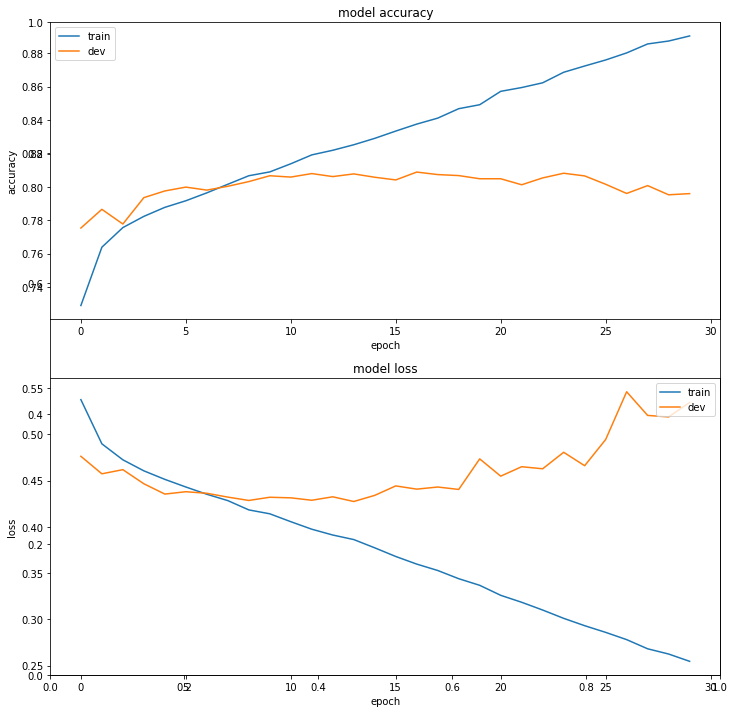

In [31]:
# summarize history for accuracy

fig, ax = plt.subplots(figsize=(12,12))
ax = fig.add_subplot(2,1,1)

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'dev'], loc='upper left')

ax = fig.add_subplot(2,1,2)
# summarize history for loss
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'dev'], loc='upper right')
fig.savefig("/content/gdrive/My Drive/checkpoints/History_self-attention_rnn.pdf")
plt.show()



#### Evaluate performance of BiLSTM + deep self-attention + MLP model on dev data


In [30]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from sklearn.metrics import classification_report

LSTM_SIZE = 400
DENSE = 300

with tf.device('/device:GPU:0'):

  inputs = Input((MAX_SEQUENCE_LENGTH,))
  embeddings = Embedding(MAX_WORDS+2,EMBEDDING_DIM, weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)
  bilstm = Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True,recurrent_dropout = 0.33))(embeddings)
  x, attn = DeepAttention(return_attention=True)(bilstm)
  hidden = Dense(units=DENSE, activation="relu")(x)
  out = Dense(units=2, activation="softmax")(hidden)
  model = Model(inputs, out)
  #load weights from the pre-trained model
  model.load_weights("/content/gdrive/My Drive/checkpoints/BiLSTM_attn.hdf5")
  
  print("Dev set performance")
  predictions = np.argmax(model.predict(test_data), -1)
  print(classification_report(y_test, predictions)) #, target_names=twenty_train.target_names

  print_classifier_scores(model, 'Keras RNN classifier', train_data, y_train
  , dev_data, y_dev
  , test_data, y_test,0.5)

Dev set performance
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      5123
           1       0.80      0.83      0.81      4877

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Keras RNN classifier- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.882 |    0.852 | 0.867 |
| 1     |       0.858 |    0.886 | 0.872 |
| macro |       0.87  |    0.869 | 0.869 |
+-------+-------------+----------+-------+
---------------------------------------------------------
Keras RNN classifier- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.818 |    0.791 | 0.804 |
| 1     |       0.801 |    0.827 | 0.814 |
| macro |

### Precision - Recall Curve


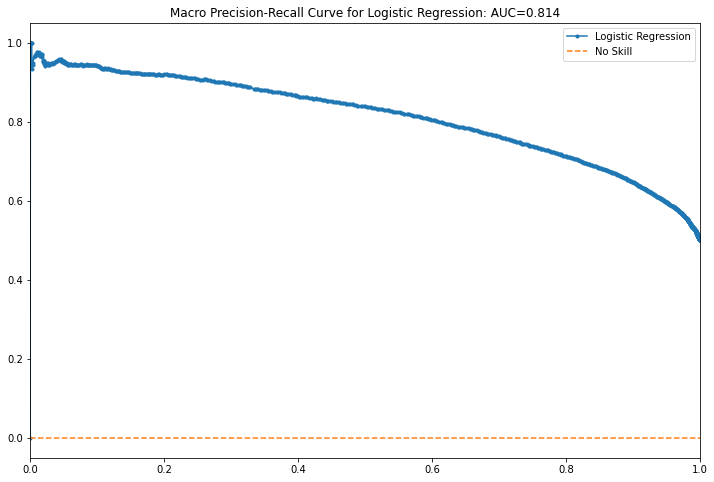

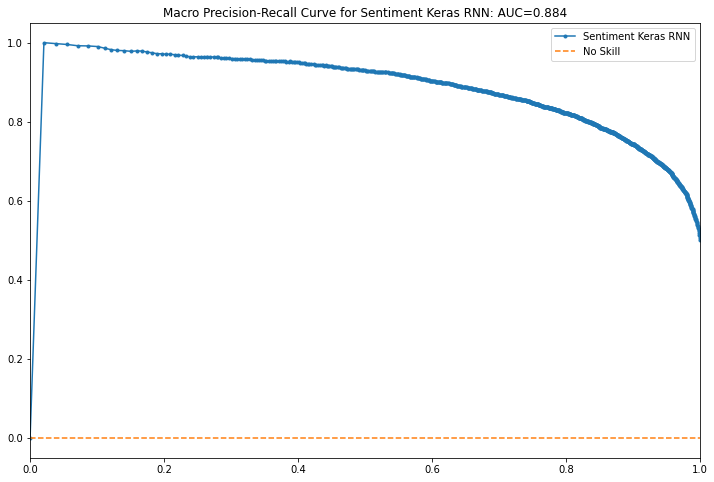

In [35]:
def plot_precision_recall_curve(estimator, estimator_name, X, y_true, is_keras=True):
  # predict using given estimator

  if is_keras:
    y_pred = estimator.predict(X)
  else:
    y_pred = estimator.predict_proba(X)
  precisions = []
  recalls = []
  
  # thresholds list
  thres = np.linspace(0,1,1000)

  # keep scores for each threshold
  for t in thres:
    prec_dict, rec_dict, _ = get_scores(y_true, y_pred, t)

    precisions.append(prec_dict['macro'])
    recalls.append(rec_dict['macro'])

  # calculate area-under-curve
  area = auc(recalls, precisions)

  # plot
  fig, ax = plt.subplots(figsize=(12,8))
  ax.set_title('Macro Precision-Recall Curve for %s: AUC=%0.3f' % (estimator_name,area))
  ax.plot(recalls, precisions, marker='.', label=estimator_name)
  ax.plot(thres,np.zeros(len(thres)), linestyle='--', label='No Skill')
  ax.set_xlim(0,1)
  ax.legend()
  fig.savefig("/content/gdrive/My Drive/checkpoints/"+str(estimator_name)+"_PR_CURVE.pdf")


pipeline_list = [
                 [lg_pipeline,'Logistic Regression',False]
                ,[model,'Sentiment Keras RNN',True]
               ]

for pipe in pipeline_list:
  plot_precision_recall_curve(pipe[0], pipe[1], test_data, y_test, is_keras=pipe[2])

#### Bootstrap Statistical Significance Tests

In [ ]:
# Initialize classifiers ##########################################
# Base
y_pred = base_pipeline.predict_proba(test_data)
_, _, bs_f1 = get_scores(y_test, y_pred, 0.5)
print('Base macro-f1: {:.4f}'.format( bs_f1['macro']))

# SGD
y_pred = lg_pipeline.predict_proba(test_data)
_, _, sgd_f1 = get_scores(y_test, y_pred, 0.5)
print('SGD macro-f1: {:.4f}'.format(sgd_f1['macro']))

# Keras
y_pred = model.predict(test_data)
_, _, ks_f1 = get_scores(y_test, y_pred, 0.5)
print('Keras macro-f1: {:.4f}'.format( ks_f1['macro']))

Base macro-f1: 0.3278
SGD macro-f1: 0.7398
Keras macro-f1: 0.8106


In [ ]:
# Bootstrapping significance test ###################################

def bootstrap_sign_test(best_estimator, comp_estimator, X, y, b, N):
  """
  Input:
    best_estimator: best scoring keras estimator in terms of macro-f1
    comp_estimator: pipeline to be compared with the best
    X: array with X dataset
    y: 
    b: number of sampling datasets
    N: size of sampling datasets

  Output:
    p_value: p-value for the bootstrapping significance test
  """
  y1 = best_estimator.predict(X)
  _, _, e1_f1 = get_scores(y, y1, 0.5)

  y2 = comp_estimator.predict_proba(X)
  _, _, e2_f1 = get_scores(y, y2, 0.5)
  
  # calculate true difference
  delta = e1_f1['macro'] - e2_f1['macro']

  diffs = []

  # calculate a diff for each simulated sample dataset
  for i in range(b):
    # generate N random indexes with replacement
    random_idx = np.random.choice(X.shape[0], N, replace=True) 
    bootstrap = X[random_idx, :]
    y_best = best_estimator.predict( bootstrap )
    y_comp = comp_estimator.predict_proba( bootstrap )

    _, _, best_f1 = get_scores(y[random_idx], y_best, 0.5)
    _, _, comp_f1 = get_scores(y[random_idx], y_comp, 0.5)
    diffs.append(best_f1['macro'] - comp_f1['macro'])
  
  # calculate p-value
  s = 0
  for i in range(b):
    if diffs[i] > 2 * delta:
      s += 1
  p_value = s/b
  
  return p_value

# print p-values
start_time = time.time()

print('Keras vs Baseline, p_value:  {:.4f}' .format( bootstrap_sign_test(model, base_pipeline, test_data, y_test, b = 1000, N = 1000) ))
print('Keras vs Logistic Regression, p_value: {:.4f}' .format( bootstrap_sign_test(model, lg_pipeline, test_data, y_test, b = 1000, N = 1000) ))

elapsed_time = time.time() - start_time

print('Elapsed time {:.0f} seconds'.format(elapsed_time))

Keras vs Baseline, p_value:  0.0000
Keras vs Logistic Regression, p_value: 0.0000
Elapsed time 3234 seconds


#### Learning Curves

Process ended for trainsize: 10.0 % :
Process ended for trainsize: 32.5 % :
Process ended for trainsize: 55.00000000000001 % :
Process ended for trainsize: 77.5 % :
Process ended for trainsize: 100.0 % :


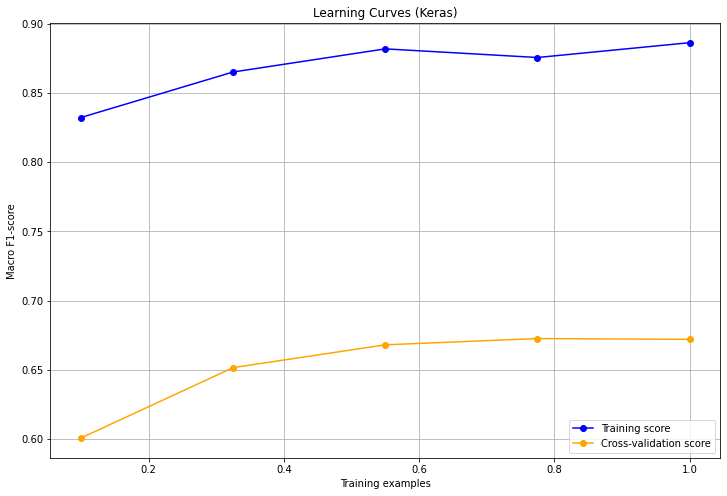

In [ ]:
def plot_learning_curve(estimator, title, X, y, X_dev, y_dev, ylim=None, train_sizes=np.linspace(.1, 1.0, 5), is_keras=False):
  
  total_length = X.shape[0] 
  fig, ax = plt.subplots(figsize=(12,8))
  ax.set_title(title)
  if ylim is not None:
    ax.set_ylim(*ylim)
  ax.set_xlabel("Training examples")
  ax.set_ylabel("Macro F1-score")

  f1_train = []
  f1_dev = []

  # for each training subset, fit and predict
  for t_sz in train_sizes:
    X_subset = X[:int(t_sz * total_length)]
    y_subset = y[:int(t_sz * total_length)]

    # make y 2-dim if estimator is keras
    if is_keras==True:
      # fit MLP estimator
      y_subset2 = np.vstack(( 1-y_subset, y_subset)).T
      y_dev2 = np.vstack(( 1-y_dev, y_dev)).T
      
      estimator.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=0.001),
                    metrics=["accuracy"])
      
      estimator.fit(X_subset, y_subset2,
              batch_size=128,
              epochs=30,
              verbose = 0,
              #callbacks=my_callbacks, we dont need callbacks now
              #validation_data=(X_dev, y_dev2),
              shuffle=True)
    else:
        # fit sklearn estimator
        estimator.fit(X_subset, y_subset2)
    
    if is_keras==True:  
      y_pred = estimator.predict(X_subset)
      y_pred_dev = estimator.predict(X_dev)
    else:
      y_pred = estimator.predict_proba(X_subset)
      y_pred_dev = estimator.predict_proba(X_dev)

    _, _, f1_dict = get_scores(y_subset, y_pred, 0.5)
    _, _, f1_dict_dev = get_scores(y_dev, y_pred_dev, 0.5)
    f1_train.append(f1_dict['macro'])
    f1_dev.append(f1_dict_dev['macro'])
    print("Process ended for trainsize: {.2f} % :".format(t_sz*100))

  ax.grid()
  ax.plot(train_sizes, f1_train, 'o-', color="b",
            label="Training score")
  ax.plot(train_sizes, f1_dev, 'o-', color="orange",
            label="Cross-validation score")

  ax.legend(loc="lower right")
  fig.savefig("/content/gdrive/My Drive/checkpoints/"+title+'.pdf')

start_time = time.time()
plot_learning_curve(model, "Learning Curves (Keras)"
                    , train_data, y_train
                    , dev_data, y_dev
                    , train_sizes = np.linspace(.1, 1.0, 5)
                    ,is_keras = True
                    )
elapsed_time = time.time() - start_time

print('Elapsed time {:.0f} seconds'.format(elapsed_time))

### Appendix A - Randomized GridSearch

In [ ]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import Model

def my_model(drp1, drp2, drp3, drp4, lstm_sz, dns_sz, is_deep):

  inputs = Input((MAX_SEQUENCE_LENGTH,))
  embeddings = Embedding(MAX_WORDS+2,EMBEDDING_DIM, weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)
  drop_emb = Dropout(drp1)(embeddings)
  bilstm = Bidirectional(LSTM(units=lstm_sz, return_sequences=True,recurrent_dropout = 0.33))(drop_emb)
  drop_encodings = Dropout(drp2)(bilstm)

  if is_deep:
    x, attn = DeepAttention(return_attention=True)(drop_encodings)
  else:
    x, attn = LinearAttention(return_attention=True)(drop_encodings)

  drop_x = Dropout(drp3)(x)
  hidden = Dense(units=dns_sz, activation="relu")(drop_x)
  drop_out = Dropout(drp4)(hidden)
  out = Dense(units=2, activation="softmax")(drop_out)
  model = Model(inputs, out)

  model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=0.001),
                    metrics=["accuracy"])

  return model

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

drp1 = [0.33, 0.4]
drp2 = [0.33, 0.4]
drp3 = [0.33, 0.4]
drp4 = [0.33, 0.4]

lstm_sz = [300, 400]
dns_sz = [200, 300, 400]
is_deep = [True, False]


model = KerasClassifier(build_fn = my_model, epochs = 20, batch_size = 32, verbose = 1)

param_grid = dict(drp1 = drp1, drp2 = drp2, drp3 = drp3, drp4 = drp4, lstm_sz = lstm_sz, dns_sz = dns_sz, is_deep = is_deep)

grid = RandomizedSearchCV(estimator = model, n_iter = 8
                          , param_distributions = param_grid
                          , n_jobs = 1, cv = 3, verbose = 3
                          , scoring = 'f1_macro')

grid_result = grid.fit(train_data, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] lstm_sz=400, is_deep=True, drp4=0.4, drp3=0.33, drp2=0.4, drp1=0.33, dns_sz=300 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
1667/1667 [==============================] - 584s 350ms/step - loss: 0.5465 - accuracy: 0.7234
Epoch 2/20
1667/1667 [==============================] - 581s 348ms/step - loss: 0.4932 - accuracy: 0.7637
Epoch 3/20
1667/1667 [==============================] - 579s 347ms/step - loss: 0.4744 - accuracy: 0.7743
Epoch 4/20
1667/1667 [==============================] - 579s 348ms/step - loss: 0.4613 - accuracy: 0.7805
Epoch 5/20
1667/1667 [==============================] - 581s 349ms/step - loss: 0.4501 - accuracy: 0.7883
Epoch 6/20
1667/1667 [==============================] - 582s 349ms/step - loss: 0.4401 - accuracy: 0.7956
Epoch 7/20
1667/1667 [==============================] - 581s 348ms/step - loss: 0.4310 - accuracy: 0.7993
Epoch 8/20
1667/1667 [==============================] - 575s 345ms/step - loss: 0.4205 - accuracy: 0.8061
Epoch 9/20
1667/1667 [==============================] - 571s 343ms/step - loss: 0.4093 - accuracy: 0.8122
Epoch 10/20
1667/1667 [=======================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 191.9min remaining:    0.0s


Epoch 1/20
1667/1667 [==============================] - 572s 343ms/step - loss: 0.5444 - accuracy: 0.7242
Epoch 2/20
1667/1667 [==============================] - 562s 337ms/step - loss: 0.4914 - accuracy: 0.7645
Epoch 3/20
1667/1667 [==============================] - 555s 333ms/step - loss: 0.4749 - accuracy: 0.7754
Epoch 4/20
1667/1667 [==============================] - 563s 337ms/step - loss: 0.4611 - accuracy: 0.7818
Epoch 5/20
1667/1667 [==============================] - 559s 335ms/step - loss: 0.4482 - accuracy: 0.7889
Epoch 6/20
1667/1667 [==============================] - 558s 335ms/step - loss: 0.4410 - accuracy: 0.7940
Epoch 7/20
1667/1667 [==============================] - 568s 341ms/step - loss: 0.4310 - accuracy: 0.7986
Epoch 8/20
1667/1667 [==============================] - 591s 354ms/step - loss: 0.4217 - accuracy: 0.8062
Epoch 9/20
1667/1667 [==============================] - 589s 353ms/step - loss: 0.4111 - accuracy: 0.8116
Epoch 10/20
1667/1667 [=======================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 385.6min remaining:    0.0s


Epoch 1/20
1667/1667 [==============================] - 579s 347ms/step - loss: 0.5529 - accuracy: 0.7175
Epoch 2/20
1667/1667 [==============================] - 567s 340ms/step - loss: 0.4954 - accuracy: 0.7600
Epoch 3/20
1667/1667 [==============================] - 574s 344ms/step - loss: 0.4785 - accuracy: 0.7716
Epoch 4/20
1667/1667 [==============================] - 577s 346ms/step - loss: 0.4632 - accuracy: 0.7827
Epoch 5/20
1667/1667 [==============================] - 582s 349ms/step - loss: 0.4489 - accuracy: 0.7906
Epoch 6/20
1667/1667 [==============================] - 615s 369ms/step - loss: 0.4414 - accuracy: 0.7935
Epoch 7/20
1667/1667 [==============================] - 625s 375ms/step - loss: 0.4288 - accuracy: 0.8010
Epoch 8/20
1667/1667 [==============================] - 594s 356ms/step - loss: 0.4188 - accuracy: 0.8068
Epoch 9/20
1667/1667 [==============================] - 624s 374ms/step - loss: 0.4098 - accuracy: 0.8139
Epoch 10/20
1667/1667 [=======================